![dataworks-logo](images/dataworks-logo.png)
![ccdc-logo](images/logo.png)

# Introduction to Neural Networks for Deep Learning with TensorFlow

In [1]:
import numpy as np
import matplotlib as mlp
import matplotlib.pyplot as plt 

from PIL import Image 

import tensorflow as tf

print(tf.__version__)

2.3.0


# TensorFlow Example - Binary Image Classification 

In this case study, we will build two neural networks to classify images.  Our dataset consists of images of either Agni or the Darwin.  Our neural network will train on a dataset and predict if a new image is of Agni or Darwin.  We will compare the performance of a traditional dense feed-forward neural network (**mutli-layer perceptron**) and a simple **convolutional neural network**.  

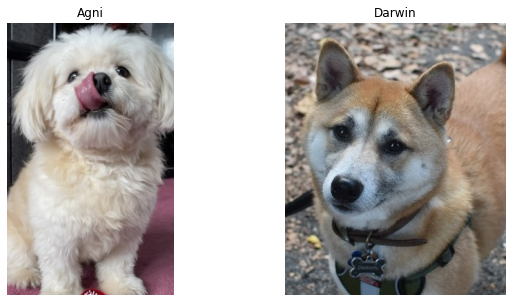

In [2]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ims = [("dataset_01/train/agni/slurp.jpg", "Agni"), ("dataset_01/train/darwin/such-wow.jpg", "Darwin")]

for idx, a in enumerate(ax): 
    a.imshow(Image.open(ims[idx][0]))
    a.set_title(ims[idx][1])
    a.axis(False)

### Preprocess dataset

We will be working with image data in this example.  The dataset of images vary in dimension, so we will preprocess them all to the same size.  In addition, to simulate having a larger dataset, we will apply **data augmentation**.  Data augmentation is a technique used to increase the diversity of a training set by applying random transformations (e.g. image rotations, zooms, shearing).  

Text(0.5, 1.0, 'Processed Img')

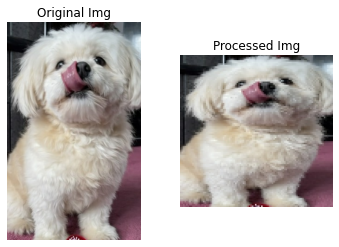

In [3]:
# Read in image and preprocess 
IMG_H, IMG_W, CHANNELS = (100, 100, 3)

img_str = tf.io.read_file('dataset_01/train/agni/slurp.jpg')
img_dec = tf.image.decode_jpeg(img_str)
img_dec = tf.image.convert_image_dtype(img_dec, dtype=tf.float32, saturate=False)
img_reduced = tf.image.resize(img_dec, (IMG_H, IMG_W))
img_data = np.expand_dims(img_reduced, axis=0)
img_data = img_data / 255.0

fig, axes = plt.subplots(1, 2)

axes[0].imshow(img_dec)
axes[0].axis(False)
axes[0].set_title('Original Img')

axes[1].imshow(img_reduced)
axes[1].axis(False)
axes[1].set_title('Processed Img')


We will leverage TensorFlow APIs for dataset management.  Namely, TensorFlow v2+ has great utilities for image data management.  

In [4]:
IMG_H, IMG_W, CHANNELS = (50, 50, 3)

In [5]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        'dataset_01/train', 
        target_size=(50, 50), 
        batch_size=16,  
        class_mode='binary')

test_generator = test_datagen.flow_from_directory(
        'dataset_01/test', 
        target_size=(50, 50), 
        class_mode='binary')


Found 65 images belonging to 2 classes.
Found 4 images belonging to 2 classes.


The above cell creates TensorFlow dataset generators.  When invoked, these objects will grab a dataset image, apply image augmentation, and serve it to our model for training at execution time.  This is a very useful tool for building machine learning pipelines for large datasets.  

See the image below for what a batch of training data images could look like.  The subplot titles represent a binary classification.  

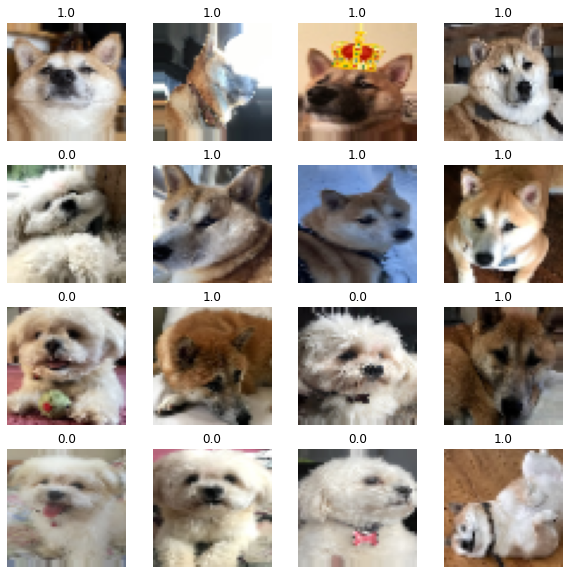

In [6]:
for a, b in train_generator:
    fig, axes = plt.subplots(4, 4, figsize=(10, 10))
    for idx, ax in enumerate(axes.reshape(-1)): 
        ax.imshow(a[idx])
        ax.set_title(b[idx])
        ax.axis(False)
        
    break  

### Multilayer Perceptron 

A multilayer perceptron is the most basic feedforward neural network architecture.  It consists only densely connected layers.  We will build this model using TensorFlow.  

In [7]:
from tensorflow.keras.layers import Flatten, Dense 

In [8]:
# Define model architecture 
model = tf.keras.Sequential([
    Flatten(input_shape=(IMG_H, IMG_W, CHANNELS)), 
    Dense(10, activation='relu'), 
    Dense(1, activation='sigmoid'), 
])


# Compile model -- define loss function, optimization strategy, and other training-time parameters  
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 7500)              0         
_________________________________________________________________
dense (Dense)                (None, 10)                75010     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 11        
Total params: 75,021
Trainable params: 75,021
Non-trainable params: 0
_________________________________________________________________


In [9]:
# Conduct model training.  The train_generator will feed batches of training data to the model 
history = model.fit(train_generator, 
                   epochs=50, 
                   verbose=1)

Epoch 1/50
5/5 [==============================] - 0s 23ms/step - loss: 0.9590 - accuracy: 0.6462
Epoch 2/50
5/5 [==============================] - 0s 30ms/step - loss: 1.1949 - accuracy: 0.5538
Epoch 3/50
5/5 [==============================] - 0s 36ms/step - loss: 1.1635 - accuracy: 0.5538
Epoch 4/50
5/5 [==============================] - 0s 39ms/step - loss: 0.6442 - accuracy: 0.6000
Epoch 5/50
5/5 [==============================] - 0s 32ms/step - loss: 0.6888 - accuracy: 0.5846
Epoch 6/50
5/5 [==============================] - 0s 32ms/step - loss: 0.6287 - accuracy: 0.5692
Epoch 7/50
5/5 [==============================] - 0s 33ms/step - loss: 0.5988 - accuracy: 0.6923
Epoch 8/50
5/5 [==============================] - 0s 36ms/step - loss: 0.5941 - accuracy: 0.6308
Epoch 9/50
5/5 [==============================] - 0s 31ms/step - loss: 0.7046 - accuracy: 0.6154
Epoch 10/50
5/5 [==============================] - 0s 45ms/step - loss: 0.8945 - accuracy: 0.5231
Epoch 11/50
5/5 [============

Learning curves are plots of model metrics against epoch of training.  Assessing these plots helps understand the performance of our model as it trains.  

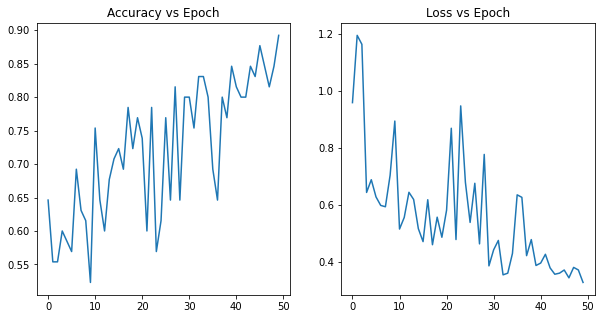

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
x_ = np.arange(len(history.history['accuracy']))
y_ = ((history.history['accuracy'], 'Accuracy'), 
      (history.history['loss'], 'Loss'))

for idx, ax in enumerate(axes): 
    ax.plot(x_, y_[idx][0])
    ax.set_title('{} vs Epoch'.format(y_[idx][1]))


Apply our completely trained model to a set of test images that were left out of training.  We see here that the multilayer perceptron model performs poorly on the test set.  

H:\Anaconda\envs\dataworks-2021\lib\site-packages\matplotlib\text.py:1215: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


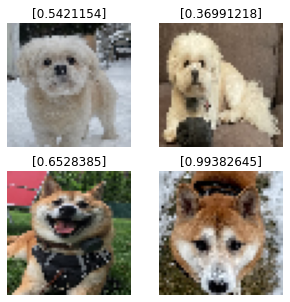

In [11]:
for a, _ in test_generator:
    fig, axes = plt.subplots(2, 2, figsize=(5, 5))
    pred = model.predict(a)
        
    for idx, ax in enumerate(axes.reshape(-1)): 
        ax.imshow(a[idx])   
        ax.set_title(pred[idx]) 
        ax.axis(False)
    
    break 

### Convolutional Neural Network 

Reference [this tutorial notebook on convolutional neural networks](appendix/convolutional-neural-networks.ipynb) for some background theory on this neural network variant.  

In [12]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D

In [13]:
model_conv = tf.keras.Sequential([
    Conv2D(16, (3, 3), padding='same', activation='relu', input_shape=(IMG_H, IMG_W, CHANNELS)),
    MaxPooling2D((2, 2)), 
    Conv2D(32, (3, 3), padding='same', activation='relu'), 
    MaxPooling2D((2, 2)), 
    Flatten(), 
    Dense(16, activation='relu'),  
    Dense(1, activation='sigmoid')
])

In [14]:
model_conv.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

history_conv = model_conv.fit(train_generator, 
                              epochs=100, 
                              verbose=1)

Epoch 1/100
5/5 [==============================] - 0s 22ms/step - loss: 0.8768 - accuracy: 0.4923
Epoch 2/100
5/5 [==============================] - 0s 30ms/step - loss: 0.6999 - accuracy: 0.5538
Epoch 3/100
5/5 [==============================] - 0s 31ms/step - loss: 0.6783 - accuracy: 0.5692
Epoch 4/100
5/5 [==============================] - 0s 33ms/step - loss: 0.6689 - accuracy: 0.7077
Epoch 5/100
5/5 [==============================] - 0s 32ms/step - loss: 0.6665 - accuracy: 0.6769
Epoch 6/100
5/5 [==============================] - 0s 36ms/step - loss: 0.6411 - accuracy: 0.6000
Epoch 7/100
5/5 [==============================] - 0s 33ms/step - loss: 0.6275 - accuracy: 0.5692
Epoch 8/100
5/5 [==============================] - 0s 31ms/step - loss: 0.6039 - accuracy: 0.6769
Epoch 9/100
5/5 [==============================] - 0s 32ms/step - loss: 0.5949 - accuracy: 0.7077
Epoch 10/100
5/5 [==============================] - 0s 35ms/step - loss: 0.5767 - accuracy: 0.6000
Epoch 11/100
5/5 [=

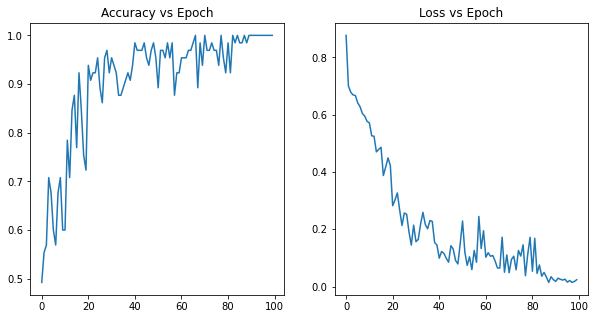

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
x_ = np.arange(len(history_conv.history['accuracy']))
y_ = ((history_conv.history['accuracy'], 'Accuracy'), 
      (history_conv.history['loss'], 'Loss'))

for idx, ax in enumerate(axes): 
    ax.plot(x_, y_[idx][0])
    ax.set_title('{} vs Epoch'.format(y_[idx][1]))


H:\Anaconda\envs\dataworks-2021\lib\site-packages\matplotlib\text.py:1215: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


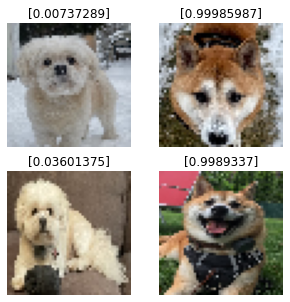

In [16]:
for a, _ in test_generator:
    fig, axes = plt.subplots(2, 2, figsize=(5, 5))
    pred = model_conv.predict(a)
        
    for idx, ax in enumerate(axes.reshape(-1)): 
        ax.imshow(a[idx])   
        ax.set_title(pred[idx]) 
        ax.axis(False)
    
    break 